In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from emtf_algos import *

In [2]:
import sys
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Set np.random seed
np.random.seed(2026)

import tensorflow as tf
import keras
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(K.get_session().list_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))

%matplotlib inline

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-requests/2.21.0-pafccj2/lib/python2.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (2.2.1) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 2.7.14+ (default, Apr 19 2019, 15:48:06) [GCC 7.4.1 20190129]
[INFO    ] Using numpy      : 1.16.2
[INFO    ] Using tensorflow : 1.6.0
[INFO    ] Using keras      : 2.2.4
[INFO    ] .. list devices  : [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using matplotlib : 2.2.4


In [3]:
# Settings

zone = 0

nevents = 200000

# Input files
signal = 'signal_add.0.npz'
bkgnd = 'bkgnd_add.0.npz'

# Image format
num_channels = 1 + 2
num_cols, col_offset = 300, 20  # truncate the first 20 columns
num_rows = 10
image_format = (num_rows, num_cols, num_channels)
assert((max_emtf_strip//coarse_emtf_strip) == num_cols + col_offset)

# Parameter
num_pars = 5

# q/pT and d0 binning
#invpt_bins = np.array([-0.5, -0.3, -0.1, 0.1, 0.3, 0.5])
#dzero_bins = np.array([-150., -90., -30., 30., 90., 150.])

# Customise
if zone == 0:
  pref_row = 4
  invpt_bins = np.array([-0.49277655, -0.24515343, -0.06501561, 0.06501561, 0.24515343, 0.49277655])
  dzero_bins = np.array([-149.01635796, -80.24550629, -19.69444885, 19.69444885, 80.24550629, 149.01635796])
elif zone == 1:
  pref_row = 5
  invpt_bins = np.array([-0.49370697, -0.26011642, -0.07240327, 0.07240327, 0.26011642, 0.49370697])
  dzero_bins = np.array([-148.42751366, -75.90176582, -18.08490837, 18.08490837, 75.90176582, 148.42751366])
elif zone == 2:
  pref_row = 3
  invpt_bins = np.array([-0.4293814, -0.20216908, -0.06793304, 0.06793304, 0.20216908, 0.4293814])
  dzero_bins = np.array([-148.45433655, -73.98971748, -17.79024315, 17.79024315, 73.98971748, 148.45433655])
elif zone == 3:
  pref_row = 6
  invpt_bins = np.array([-0.4293814, -0.20216908, -0.06793304, 0.06793304, 0.20216908, 0.4293814])
  dzero_bins = np.array([-148.45433655, -73.98971748, -17.79024315, 17.79024315, 73.98971748, 148.45433655])
else:
  raise RuntimeError('Cannot recognize zone: {0}'.format(zone))

# Labels
zone_row_labels = [
  ['ME0'  , 'GE1/1', 'ME1/1', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1', 'none' ],
  ['GE1/1', 'ME1/1', 'ME1/2', 'RE1/2', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1'],
  ['ME1/2', 'RE1/2', 'RE2/2', 'ME2/2', 'ME3/2', 'RE3/2', 'ME4/2', 'RE4/2', 'none' , 'none' ],
  ['MB1'  , 'MB2'  , 'MB3'  , 'ME1/3', 'RE1/3', 'RE2/3', 'ME2/2', 'ME3/2', 'RE3/3', 'ME4/2'],
]

logger.info('Processing zone {0}'.format(zone))
logger.info('.. nevents      : {0}'.format(nevents))
logger.info('.. image_format : {0}'.format(image_format))
logger.info('.. pref_row     : {0}'.format(pref_row))
logger.info('.. invpt_bins   : {0}'.format(invpt_bins))
logger.info('.. dzero_bins   : {0}'.format(dzero_bins))

[INFO    ] Processing zone 0
[INFO    ] .. nevents      : 200000
[INFO    ] .. image_format : (10, 300, 3)
[INFO    ] .. pref_row     : 4
[INFO    ] .. invpt_bins   : [-0.49277655 -0.24515343 -0.06501561  0.06501561  0.24515343  0.49277655]
[INFO    ] .. dzero_bins   : [-149.01635796  -80.24550629  -19.69444885   19.69444885   80.24550629
  149.01635796]


In [4]:
# Utilities

class Particle(object):
  def __init__(self, part_array):
    self.invpt = part_array[0]
    self.eta = part_array[1]
    self.phi = part_array[2]
    self.vx = part_array[3]
    self.vy = part_array[4]
    self.vz = part_array[5]
    self.d0 = part_array[6]
    self.phi_s = part_array[7]
    self.sector = part_array[8]
    self.zone = part_array[9]

  def get_parameters(self):
    return (self.invpt, self.d0, self.eta, self.phi, self.invpt)

class Hit(object):
  def __init__(self, hit_array):
    self.zone = hit_array[0]
    self.zone_row = hit_array[1]
    self.zone_col = hit_array[2]
    self.emtf_phi = hit_array[3]
    self.emtf_bend = hit_array[4]
    self.emtf_theta = hit_array[5]
    self.emtf_theta_alt = hit_array[6]
    self.emtf_qual = hit_array[7]

  def get_channels(self):
    ch0 = 1.0  # valid flag
    ch1 = (1.0 * np.true_divide(self.emtf_phi, coarse_emtf_strip)) - (1.0 * self.zone_col)
    ch2 = 1.0 * self.emtf_bend
    return (ch0, ch1, ch2)

def my_digitize(x, bins):
  # first and last bins include underflow and overflow
  ind = np.searchsorted(bins, x)
  ind = np.clip(ind-1, 0, len(bins)-2)
  return ind

def find_par_row_col(par):
  (invpt, d0, eta, phi, invpt2) = par
  ind0 = my_digitize(invpt2, invpt_bins)
  ind1 = my_digitize(d0, dzero_bins)
  return (ind1, ind0)

### Load data

In [5]:
def load_signal(f):
  logger.info('Loading from {0}'.format(f))
  with np.load(f) as loaded:
    out_part = loaded['out_part']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    out_simhits = RaggedTensorValue(loaded['out_simhits_values'], loaded['out_simhits_row_splits'])
    logger.info('out_part: {0} out_hits: {1} out_simhits: {2}'.format(out_part.shape, out_hits.shape, out_simhits.shape))
  return (out_part, out_hits, out_simhits)

def load_bkgnd(f):
  logger.info('Loading from {0}'.format(f))
  with np.load(f) as loaded:
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    logger.info('out_hits_bkgnd: {0}'.format(out_hits.shape))
  return (out_hits,)

In [6]:
part_arrays, hits_arrays, simhits_arrays = load_signal(signal)
bkghits_arrays, = load_bkgnd(bkgnd)

[INFO    ] Loading from signal_add.0.npz
[INFO    ] out_part: (2115216, 10) out_hits: (2115216, None, 8) out_simhits: (2115216, None, 8)
[INFO    ] Loading from bkgnd_add.0.npz
[INFO    ] out_hits_bkgnd: (16289880, None, 8)


In [7]:
# Debug
print(part_arrays[0], hits_arrays[0], simhits_arrays[0])
print(part_arrays[1], hits_arrays[1], simhits_arrays[1])
print(part_arrays[2], hits_arrays[2], simhits_arrays[2])
print(part_arrays[3], hits_arrays[3], simhits_arrays[3])

[ -0.07286745   1.981351     2.1438558   24.857655   -25.86196
   1.2163241    6.3448358    0.39852655   1.           0.        ] [[   0    0  267 4267   14   12    0   -1]
 [   0    3  275 4404    0   18    0    0]
 [   0    4  276 4413    2   18    0   -1]
 [   0    5  277 4431    1   18    0    1]
 [   0    6  277 4433    0   19    0    1]
 [   0    7  278 4440    0   19   19    1]
 [   0    8  278 4446    0   19    0    0]] [[   0    0  267 4264    0   13    0    0]
 [   0    2  270 4324    0   14    0    0]
 [   0    3  275 4404    0   17    0    0]
 [   0    4  276 4413    0   18    0    0]
 [   0    5  277 4428    0   18    0    0]
 [   0    6  277 4434    0   19    0    0]
 [   0    7  278 4440    0   19    0    0]
 [   0    8  278 4445    0   19    0    0]]
[1.6307077e-01 1.5877699e+00 7.2498721e-01 1.7160455e+02 1.0059981e+02
 6.9927592e+00 7.0719070e+01 2.6855508e-02 0.0000000e+00 2.0000000e+00] [[   2    2  151 2408    0   88    0   -1]
 [   2    4  155 2476    3   85    0 

### Build images

In [8]:
def build_images(zone, part_arrays, hits_arrays, simhits_arrays, nevents=-1):
  _capacity = 600000  #FIXME
  images = np.zeros((_capacity, num_rows, num_cols, num_channels), dtype=np.float32)
  images_gt = np.zeros((_capacity, num_rows, num_cols, num_channels), dtype=np.float32)
  params = np.zeros((_capacity, num_pars), dtype=np.float32)
  print('Successfully reserved huge arrays.')

  zipped = zip(part_arrays, hits_arrays, simhits_arrays)
  i = 0

  # Loop over (part_arrays, hits_arrays, simhits_arrays)
  for (part_array, hits_array, simhits_array) in zipped:
    if i == _capacity or i == nevents:
      break

    # Skip if particle not in this zone
    part = Particle(part_array)
    if (int(part.zone) != zone):
      continue

    # Skip if no simhit from pref_row in this zone
    found_pref_row = False  #FIXME
    for simhit_array in simhits_array:
      simhit = Hit(simhit_array)
      if (int(simhit.zone) == zone) and (int(simhit.zone_row) == pref_row):
        found_pref_row = True
    if not found_pref_row:
      continue

    if (i%10000) == 0:
      print('Building image {0}'.format(i))

    # Fill images
    for hit_array in hits_array:
      hit = Hit(hit_array)
      if hit.zone != zone:
        continue
      assert(hit.zone_col >= 0)
      images[i, hit.zone_row, (hit.zone_col - col_offset)] = hit.get_channels()

    # Fill images_gt
    for simhit_array in simhits_array:
      simhit = Hit(simhit_array)
      if simhit.zone != zone:
        continue
      assert(simhit.zone_col >= 0)
      images_gt[i, simhit.zone_row, (simhit.zone_col - col_offset)] = simhit.get_channels()

    # Fill params
    params[i] = part.get_parameters()
    i += 1

  # Resize
  images.resize((i, num_rows, num_cols, num_channels))
  images_gt.resize((i, num_rows, num_cols, num_channels))
  params.resize((i, num_pars))
  print('DONE')
  return (images, images_gt, params)

In [9]:
images, images_gt, params = build_images(zone, part_arrays, hits_arrays, simhits_arrays, nevents=nevents)

Successfully reserved huge arrays.
Building image 0
Building image 10000
Building image 20000
Building image 30000
Building image 40000
Building image 50000
Building image 60000
Building image 70000
Building image 80000
Building image 90000
Building image 100000
Building image 110000
Building image 120000
Building image 130000
Building image 140000
Building image 150000
Building image 160000
Building image 170000
Building image 180000
Building image 190000
DONE


In [10]:
# Debug
print(len(images), len(images_gt), len(params))
print(images[0].shape, images_gt[0].shape, params[0].shape)

print(images[0][np.nonzero(images[0][...,0])])
print(images[1][np.nonzero(images[1][...,0])])
print(images[2][np.nonzero(images[2][...,0])])
print(images[3][np.nonzero(images[3][...,0])])

200000 200000 200000
(10, 300, 3) (10, 300, 3) (5,)
[[ 1.     -0.3125 14.    ]
 [ 1.      0.25    0.    ]
 [ 1.     -0.1875  2.    ]
 [ 1.     -0.0625  1.    ]
 [ 1.      0.0625  0.    ]
 [ 1.     -0.5     0.    ]
 [ 1.     -0.125   0.    ]]
[[ 1.     -0.1875  0.    ]
 [ 1.     -0.25    9.    ]
 [ 1.      0.4375  4.    ]
 [ 1.     -0.5     5.    ]
 [ 1.     -0.375   0.    ]
 [ 1.      0.125   1.    ]
 [ 1.      0.0625  0.    ]]
[[ 1.     -0.375  -7.    ]
 [ 1.      0.0625 -8.    ]
 [ 1.     -0.5    -8.    ]]
[[  1.       0.4375 -20.    ]
 [  1.      -0.3125  -5.    ]
 [  1.      -0.375    0.    ]
 [  1.      -0.5      0.    ]
 [  1.       0.       0.    ]
 [  1.      -0.1875   0.    ]
 [  1.       0.3125   0.    ]]


In [11]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# Color maps
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)

from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

cdict = {
  'blue' : ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
green_hot = LinearSegmentedColormap('green_hot', cdict)

In [12]:
# Display image

def display_image(zone, img, cmap=blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto',
            cmap=cmap, vmin=0, vmax=1.6)
  ax.set_yticks(range(len(zone_row_labels[zone])))
  ax.set_yticklabels(zone_row_labels[zone], fontsize=7)
  plt.show()

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


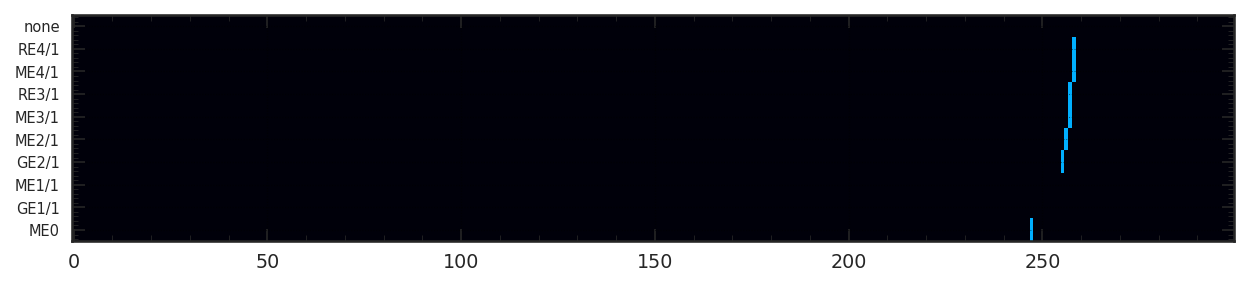

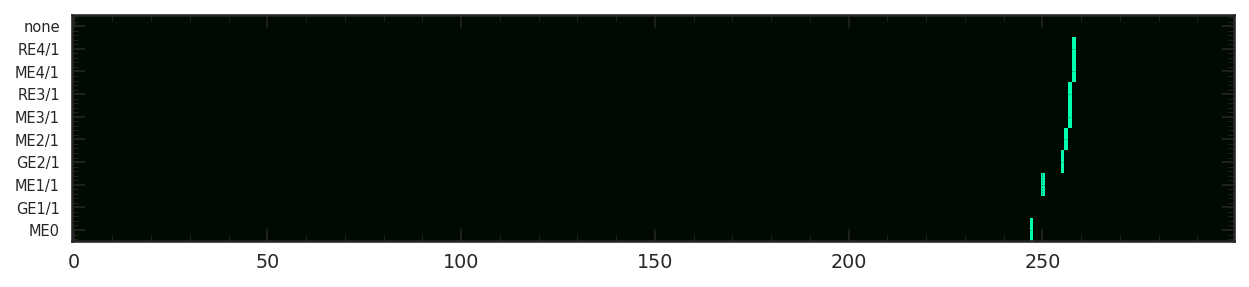

(array([0, 3, 4, 5, 6, 7, 8]), array([247, 255, 256, 257, 257, 258, 258]))
(array([0, 2, 3, 4, 5, 6, 7, 8]), array([247, 250, 255, 256, 257, 257, 258, 258]))


In [13]:
ievt = 0
display_image(zone, images[ievt])
display_image(zone, images_gt[ievt], cmap=green_hot)

print(np.nonzero(images[ievt][...,0]))
print(np.nonzero(images_gt[ievt][...,0]))

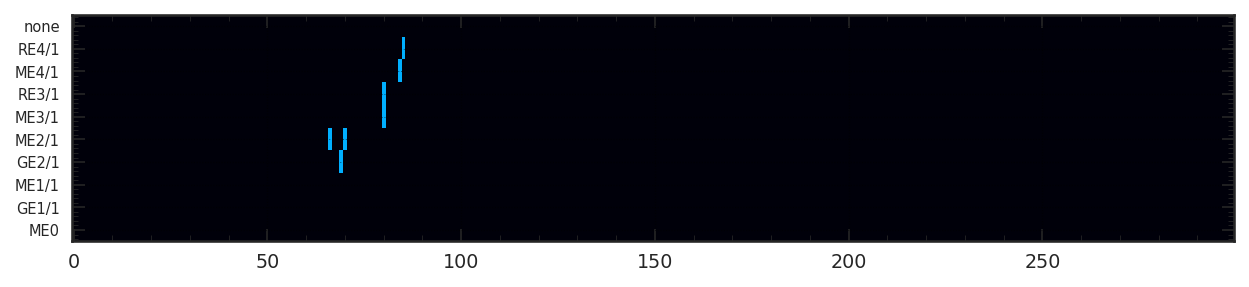

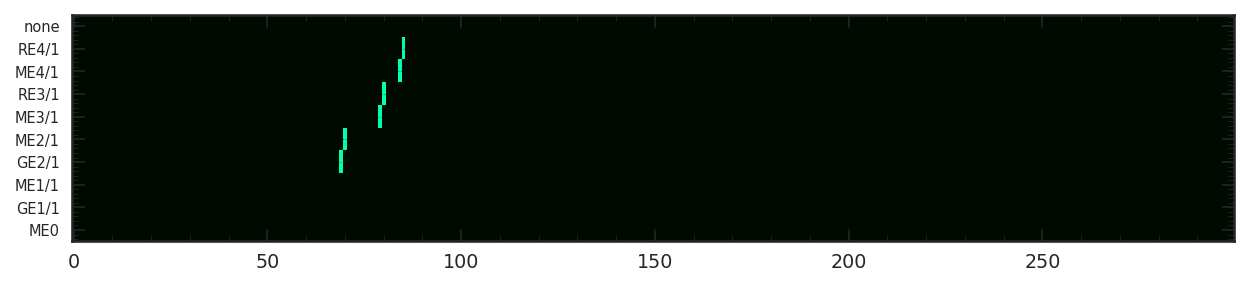

(array([3, 4, 4, 5, 6, 7, 8]), array([69, 66, 70, 80, 80, 84, 85]))
(array([3, 4, 5, 6, 7, 8]), array([69, 70, 79, 80, 84, 85]))


In [14]:
ievt = 1
display_image(zone, images[ievt])
display_image(zone, images_gt[ievt], cmap=green_hot)

print(np.nonzero(images[ievt][...,0]))
print(np.nonzero(images_gt[ievt][...,0]))

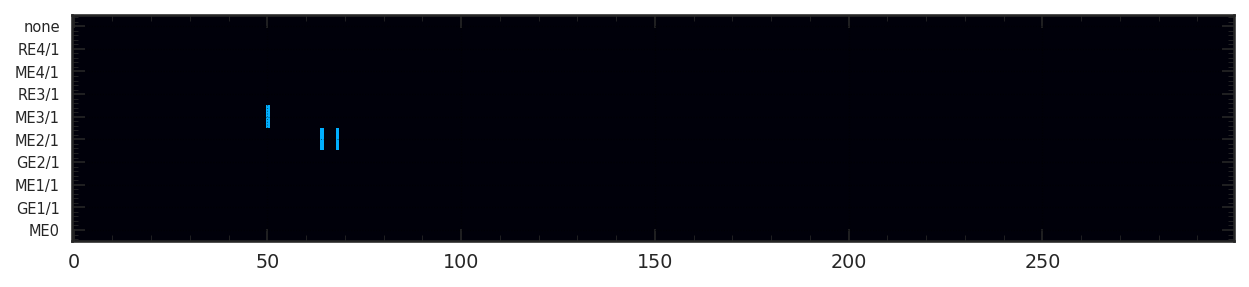

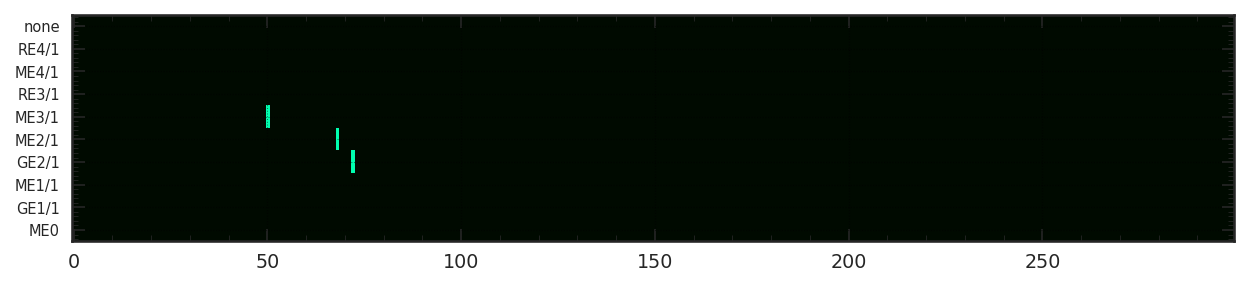

(array([4, 4, 5]), array([64, 68, 50]))
(array([3, 4, 5]), array([72, 68, 50]))


In [15]:
ievt = 2
display_image(zone, images[ievt])
display_image(zone, images_gt[ievt], cmap=green_hot)

print(np.nonzero(images[ievt][...,0]))
print(np.nonzero(images_gt[ievt][...,0]))

In [16]:
# Quick check

pref_cols = []
pref_cols_ch0 = []
pref_cols_ch1 = []
pref_cols_ch2 = []

for img_gt in images_gt[:10000]:
  pref_col = np.argmax(img_gt[pref_row, :][...,0])
  pref_cols.append(pref_col)
  pref_cols_ch0.append(img_gt[pref_row, pref_col, 0])
  pref_cols_ch1.append(img_gt[pref_row, pref_col, 1])
  pref_cols_ch2.append(img_gt[pref_row, pref_col, 2])

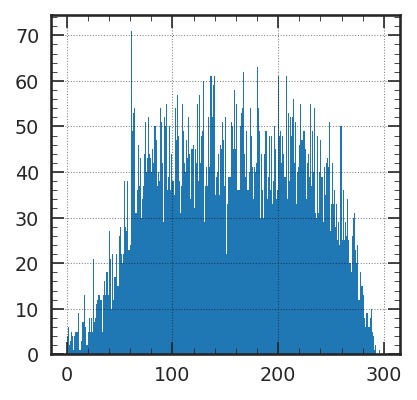

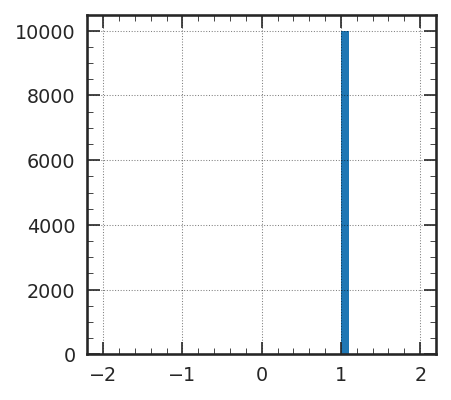

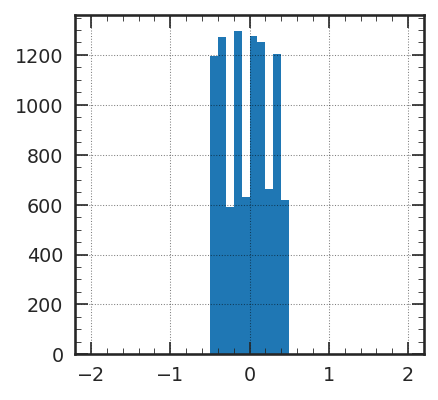

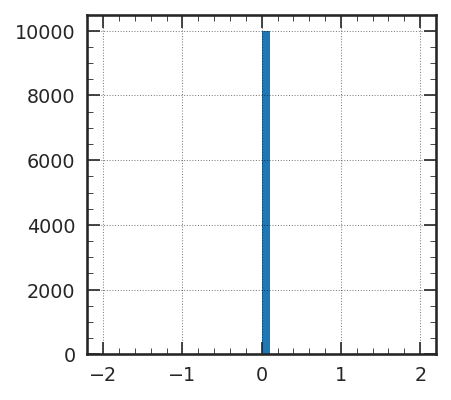

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(pref_cols, range=(0,num_cols), bins=num_cols)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(pref_cols_ch0, range=(-2,2), bins=40)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(pref_cols_ch1, range=(-2,2), bins=40)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(pref_cols_ch2, range=(-2,2), bins=40)
plt.show()

In [18]:
# Quick check

invpt_vals = []
dzero_vals = []

for par in params:
  (invpt, d0, eta, phi, invpt2) = par
  if np.abs(1.0/invpt2) >= 20.:
    dzero_vals.append(d0)
    dzero_vals.append(-d0)
  if np.abs(d0) <= 20.:
    invpt_vals.append(invpt2)
    invpt_vals.append(-invpt2)

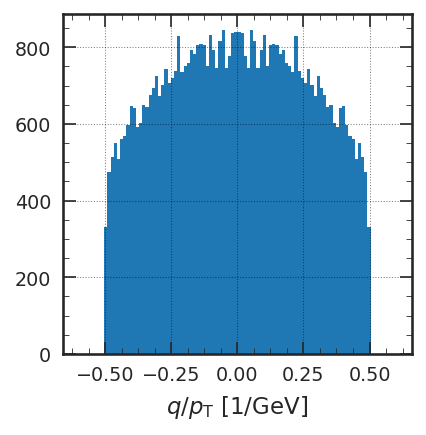

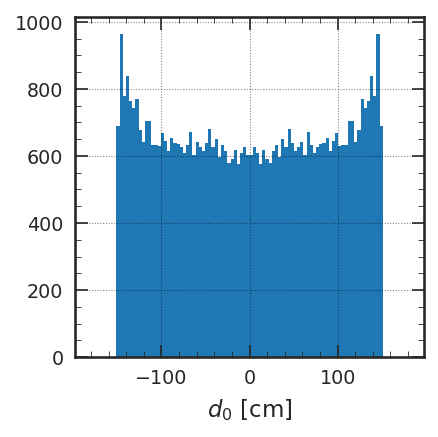

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(invpt_vals, range=(-0.6,0.6), bins=100)
ax.set_xlabel(r'$q/p_{\mathrm{T}}$ [1/GeV]')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(dzero_vals, range=(-180,180), bins=100)
ax.set_xlabel(r'$d_{0}$ [cm]')
plt.show()

In [20]:
#print('invpt binning: {0}'.format(np.percentile(invpt_vals, [0.5,20,40,60,80,99.5], overwrite_input=True)))
#print('d0 binning: {0}'.format(np.percentile(dzero_vals, [0.5,20,40,60,80,99.5], overwrite_input=True)))

print('invpt binning: {0}'.format(np.percentile(invpt_vals, [0.5,22.5,42.5,57.5,77.5,99.5], overwrite_input=True)))
print('d0 binning: {0}'.format(np.percentile(dzero_vals, [0.5,25,44,56,75,99.5], overwrite_input=True)))

invpt binning: [-0.49308416 -0.2457682  -0.06493313  0.06493313  0.2457682   0.49308416]
d0 binning: [-148.96449127  -80.15396881  -19.77953514   19.77953514   80.15396881
  148.96449127]


In [21]:
# Quick check

invpt_vals = []
dzero_vals = []

for par in params:
  (invpt, d0, eta, phi, invpt2) = par
  dzero_vals.append(d0)
  invpt_vals.append(invpt2)

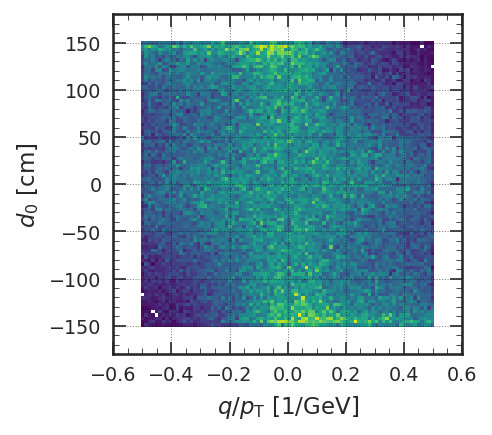

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist2d(invpt_vals, dzero_vals, range=((-0.6,0.6),(-180,180)), bins=(100,100),
              cmap=my_cmap, vmin=1)
ax.set_xlabel(r'$q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$d_{0}$ [cm]')
plt.show()

### Boxes

In [23]:
do_boxes = True

num_box_rows = num_rows

num_box_cols = 99

num_box_channels = 1

box_col_offset = 49

num_par_rows = len(invpt_bins)-1

num_par_cols = len(dzero_bins)-1

def build_boxes():
  # 5 indices: (par_row, par_col, box_row, box_col, box_channel)
  boxes = np.zeros((num_par_rows, num_par_cols, num_box_rows, num_box_cols, num_box_channels), dtype=np.float32)

  for i, (img, par) in enumerate(zip(images_gt, params)):
    if (i%10000) == 0:
      print('Building image {0}'.format(i))

    pref_col = np.argmax(img[pref_row, :][...,0])
    rows, cols = np.nonzero(img[...,0])

    par_row, par_col = find_par_row_col(par)
    mirror_par_row, mirror_par_col = (num_par_rows-1) - par_row, (num_par_cols-1) - par_col

    for row, col in zip(rows, cols):
      # canon image
      col = (col - pref_col) + box_col_offset
      if 0 <= col < num_box_cols:
        boxes[par_row, par_col, row, col] += 1.0
      # mirror image
      mirror_col = (num_box_cols-1) - col
      if 0 <= mirror_col < num_box_cols:
        boxes[mirror_par_row, mirror_par_col, row, mirror_col] += 1.0
  print('DONE')
  return boxes

In [24]:
%%time

if do_boxes:
  boxes = build_boxes()
  boxes_orig = boxes.copy()

Building image 0
Building image 10000
Building image 20000
Building image 30000
Building image 40000
Building image 50000
Building image 60000
Building image 70000
Building image 80000
Building image 90000
Building image 100000
Building image 110000
Building image 120000
Building image 130000
Building image 140000
Building image 150000
Building image 160000
Building image 170000
Building image 180000
Building image 190000
DONE
CPU times: user 20.1 s, sys: 1.92 s, total: 22 s
Wall time: 22 s


In [25]:
# Debug

if do_boxes:
  with np.printoptions(precision=3) as opts:
    print(boxes[2, 2, :, box_col_offset-5:box_col_offset+6, 0])

[[1.700e+02 1.620e+02 1.580e+02 1.960e+02 1.650e+02 1.540e+02 1.650e+02
  1.960e+02 1.580e+02 1.620e+02 1.700e+02]
 [1.150e+02 1.340e+02 1.180e+02 1.520e+02 1.310e+02 1.280e+02 1.310e+02
  1.520e+02 1.180e+02 1.340e+02 1.150e+02]
 [2.550e+02 3.140e+02 3.340e+02 3.400e+02 3.670e+02 3.640e+02 3.670e+02
  3.400e+02 3.340e+02 3.140e+02 2.550e+02]
 [0.000e+00 8.000e+00 5.500e+01 2.930e+02 1.727e+03 4.176e+03 1.727e+03
  2.930e+02 5.500e+01 8.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.680e+03 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.030e+02 2.250e+02 4.320e+02 9.430e+02 1.486e+03 1.720e+03 1.486e+03
  9.430e+02 4.320e+02 2.250e+02 1.030e+02]
 [1.560e+02 2.830e+02 5.470e+02 9.500e+02 1.242e+03 1.314e+03 1.242e+03
  9.500e+02 5.470e+02 2.830e+02 1.560e+02]
 [2.290e+02 3.860e+02 6.120e+02 7.810e+02 9.400e+02 8.940e+02 9.400e+02
  7.810e+02 6.120e+02 3.860e+02 2.290e+02]
 [2.830e+02 4.440e+02 6.200e+02 7.200e+02 8.080e+02 7.920e+02 8.080e+02
  7.200e

In [26]:
import numba

@numba.njit
def njit_pad_image(img, img_padded, pad_l, pad_t):  # based on pytorch nn.ReflectionPad2d
  for i in range(img_padded.shape[0]):
    if i < pad_t:
      ip_y = pad_t * 2 - i
    elif i >= img.shape[0] + pad_t:
      ip_y = (img.shape[0] + pad_t - 1) * 2 - i
    else:
      ip_y = i
    ip_y = ip_y - pad_t

    for j in range(img_padded.shape[1]):
      if j < pad_l:
        ip_x = pad_l * 2 - j
      elif j >= img.shape[1] + pad_l:
        ip_x = (img.shape[1] + pad_l - 1) * 2 - j
      else:
        ip_x = j
      ip_x = ip_x - pad_l

      # Padding
      img_padded[i, j] = img[ip_y, ip_x]
      #print((i,j), (ip_y,ip_x))

@numba.njit
def njit_apply_filter(img, img_padded, filt, pad_l, pad_t):
  for i in range(img_padded.shape[0]):
    for j in range(img_padded.shape[1]):
      if i >= pad_t and i < img.shape[0] + pad_t:
        if j >= pad_l and j < img.shape[1] + pad_l:
          ip_y = i - pad_t
          ip_x = j - pad_l
          field = img_padded[i-pad_t:i+pad_t+1, j-pad_l:j+pad_l+1]  # receptive field of filter

          # Matrix multiplication
          if field.sum() > 0.:
            #img[ip_y, ip_x] = np.sum(filt * field)
            for k in range(filt.shape[0]):
              for kk in range(filt.shape[1]):
                for kkk in range(filt.shape[2]):
                  img[ip_y, ip_x] += (filt[k, kk, kkk] * field[k, kk, kkk])

# Reference:
#   https://github.com/adobe/antialiased-cnns
#   https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/ReflectionPad.cpp

class Antialiaser(object):
  def __init__(self):
    self.filt_size = 3
    self.pad_l = 1
    self.pad_t = 0

    box_shape = (num_box_rows, num_box_cols, num_box_channels)
    old_shape = box_shape
    new_shape = (old_shape[0] + self.pad_t * 2, old_shape[1] + self.pad_l * 2, old_shape[2])
    self.img_orig = np.zeros(old_shape, dtype=np.float32)
    self.img_padded = np.zeros(new_shape, dtype=np.float32)

    #self.filt = np.array([1., 2., 1.])  # 1D
    self.filt = np.array([1., 4., 1.])  # 1D
    self.filt = self.filt / np.sum(self.filt)
    self.filt = self.filt.reshape(1, self.filt_size, 1)

  def __call__(self, img):
    self.img_orig *= 0
    self.img_padded *= 0

    self.img_orig += img

    # Add padding
    njit_pad_image(img, self.img_padded, self.pad_l, self.pad_t)

    # Apply filter
    njit_apply_filter(img, self.img_padded, self.filt, self.pad_l, self.pad_t)

    # Remove anti-aliasing on pref_row
    #img[pref_row, :] = self.img_orig[pref_row, :]
    return img

# As function
antialias_image = Antialiaser()

class Normalizer(object):
  def __call__(self, img):
    norm = np.sqrt(np.square(img).sum(axis=-2, keepdims=True))
    norm[norm == 0] = 1.0
    img /= norm
    img[img < 1e-2] = 0.0
    return img

# As function
normalize_image = Normalizer()

def display_boxes(zone, boxes_orig, boxes, cmap=blue_hot, figsize=(10,10)):
  fig, axs = plt.subplots(num_par_rows, num_par_cols, figsize=figsize, tight_layout=True, sharex=True, sharey=True)
  for i in range(num_par_rows):
    for j in range(num_par_cols):
      ax = axs[(num_par_rows-1)-i, j]  # axs[0,0] is top left
      img_orig = boxes_orig[i, j]
      img = boxes[i, j]
      img = antialias_image(img)
      img = normalize_image(img)
      print(i, j, img_orig.sum(), img.sum())
      ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto')
      ax.set_xticklabels([])
      ax.set_yticklabels([])
  plt.show()

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numba/0.43.1-pafccj/lib/python2.7/site-packages/numba/__init__.py:78: UserWarning: llvmlite version format not recognized!
  warnings.warn("llvmlite version format not recognized!")


0 0 73572.0 39.125526
0 1 106160.0 39.84131
0 2 102697.0 41.620625
0 3 123401.0 39.74183
0 4 128020.0 37.833084
1 0 116699.0 39.40974
1 1 113362.0 37.78672
1 2 92518.0 38.77438
1 3 114088.0 38.628925
1 4 113342.0 38.802685
2 0 91737.0 36.124683
2 1 79993.0 30.65054
2 2 59388.0 29.542473
2 3 79993.0 30.65054
2 4 91737.0 36.124683
3 0 113342.0 38.80269
3 1 114088.0 38.628925
3 2 92518.0 38.77438
3 3 113362.0 37.786728
3 4 116699.0 39.40974
4 0 128020.0 37.833084
4 1 123401.0 39.74183
4 2 102697.0 41.620625
4 3 106160.0 39.84131
4 4 73572.0 39.125526


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


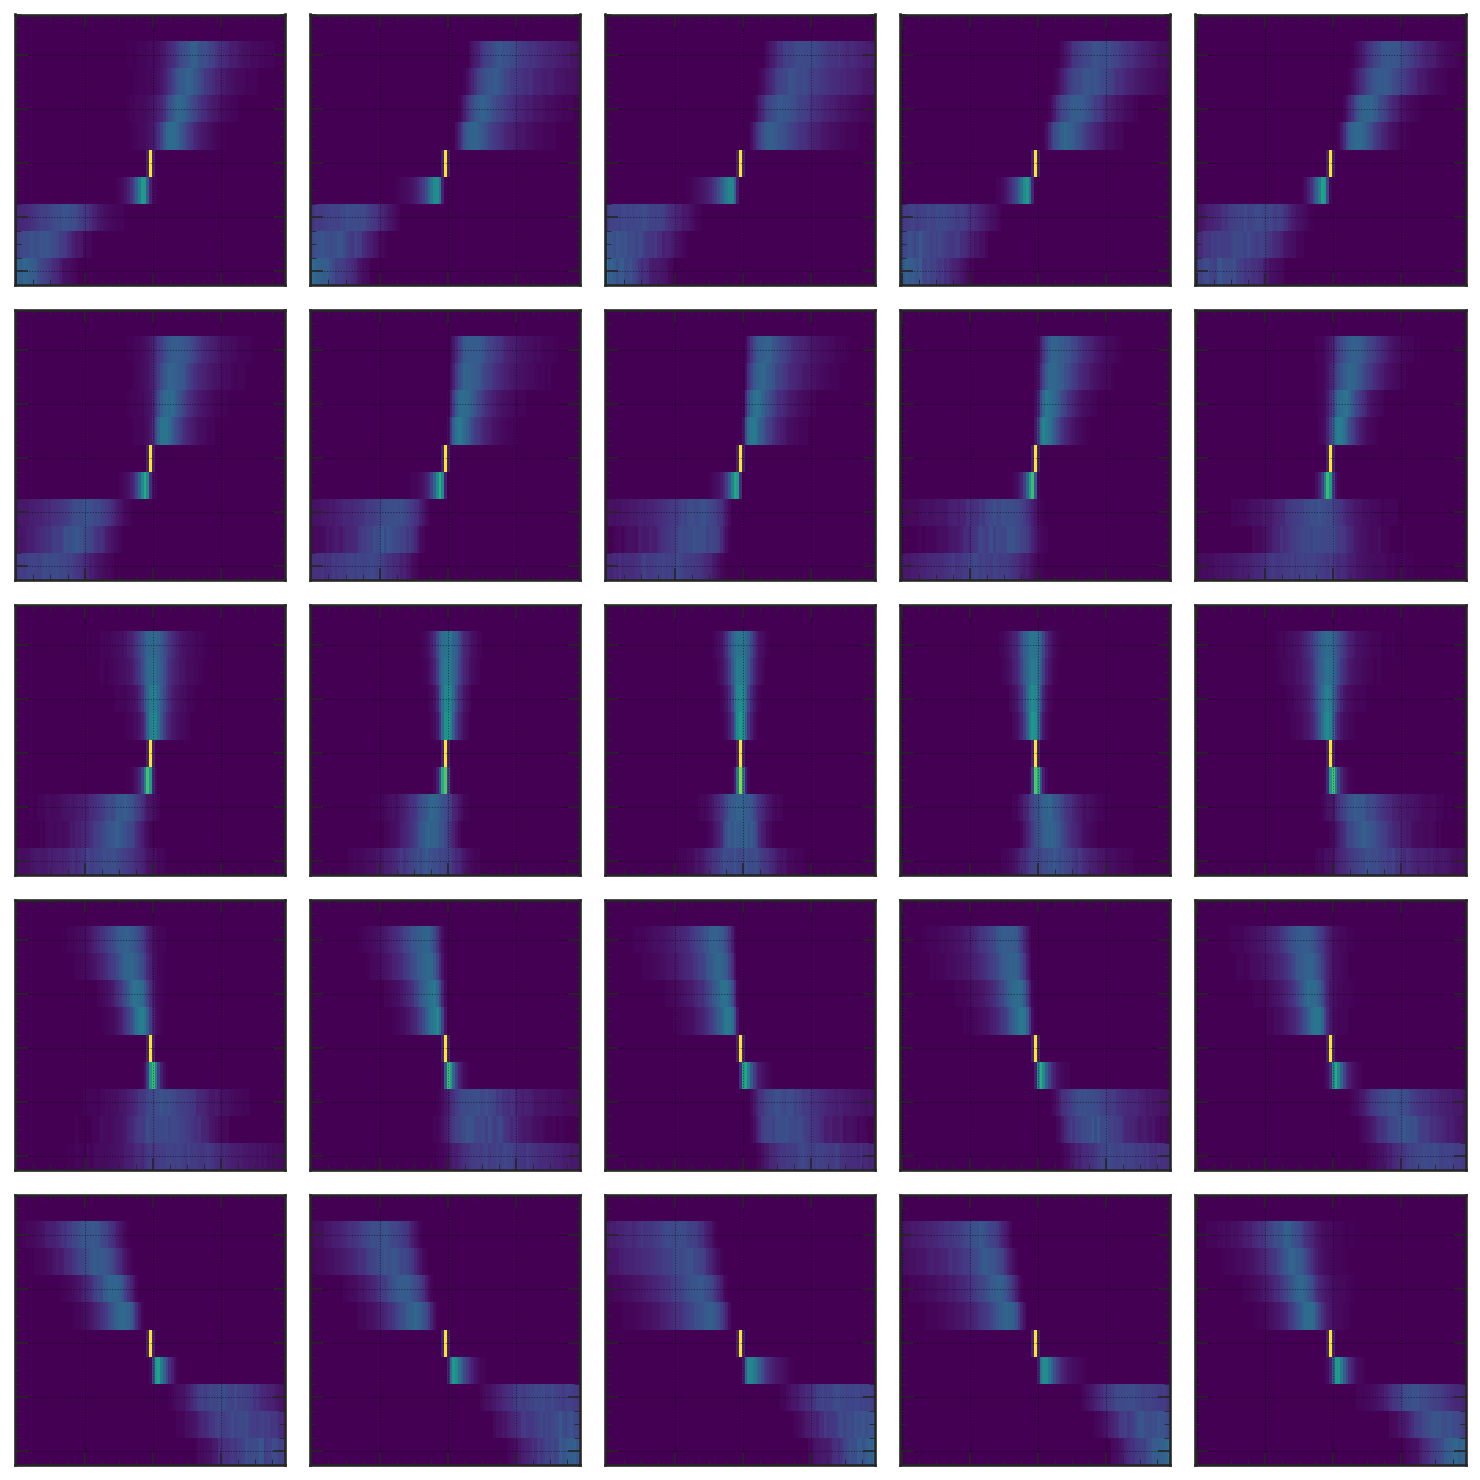

In [27]:
if do_boxes:
  boxes[:] = boxes_orig
  display_boxes(zone, boxes_orig, boxes)

In [28]:
# Debug

if do_boxes:
  with np.printoptions(precision=3) as opts:
    print(boxes[2, 2, :, box_col_offset-5:box_col_offset+6, 0])

[[0.229 0.218 0.217 0.256 0.224 0.209 0.224 0.256 0.217 0.218 0.229]
 [0.248 0.284 0.264 0.319 0.287 0.278 0.287 0.319 0.264 0.284 0.248]
 [0.216 0.264 0.283 0.29  0.31  0.31  0.31  0.29  0.283 0.264 0.216]
 [0.    0.    0.015 0.086 0.395 0.821 0.395 0.086 0.015 0.    0.   ]
 [0.    0.    0.    0.    0.099 0.99  0.099 0.    0.    0.    0.   ]
 [0.035 0.076 0.149 0.308 0.475 0.547 0.475 0.308 0.149 0.076 0.035]
 [0.059 0.109 0.206 0.348 0.452 0.481 0.452 0.348 0.206 0.109 0.059]
 [0.106 0.176 0.273 0.35  0.414 0.405 0.414 0.35  0.273 0.176 0.106]
 [0.137 0.213 0.294 0.345 0.383 0.381 0.383 0.345 0.294 0.213 0.137]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]


In [29]:
if do_boxes:
  # Write
  outfile = 'boxes_zone%i.npz' % zone
  save_np_arrays(outfile, dict(boxes=boxes, boxes_orig=boxes_orig))
  logger.info('Wrote to {0}'.format(outfile))
else:
  # Read
  infile = 'boxes_zone%i.0.npz' % zone
  logger.info('Loading from {0}'.format(infile))
  with np.load(infile) as f:
    boxes = f['boxes']
    boxes_orig = f['boxes_orig']

[INFO    ] Wrote to boxes_zone0.npz


### Annotations

In [30]:
#FIXME
if True:
  # Read
  infile = 'boxes_zone%i.0.npz' % zone
  logger.info('Loading from {0}'.format(infile))
  with np.load(infile) as f:
    boxes = f['boxes']
    boxes_orig = f['boxes_orig']
  print(boxes.shape)

[INFO    ] Loading from boxes_zone0.0.npz


(5, 5, 10, 99, 1)


In [31]:
do_annotations = True

@numba.njit
def njit_apply_boxes(img, boxes, annot, pad_l, pad_t):
  box0 = boxes[0]

  for i in range(0,1):
    for j in range(img.shape[1]):
      start = max(0, j-pad_l)
      end = min(img.shape[1], j+pad_l+1)
      b_start = max(0, box0.shape[1] - end)
      b_end = min(box0.shape[1], img.shape[1] - start)
      #assert(len(range(start, end)) == len(range(b_start, b_end)))
      #assert(img.shape[-1] == 1 and box0.shape[-1] == 1)

      # Matrix multiplication
      sub_img = img[:, start:end, 0]
      if sub_img.sum() > 0.:
        for k in range(boxes.shape[0]):
          sub_box = boxes[k, :, b_start:b_end, 0]
          #annot[k, j] = np.sum(sub_box * sub_img)
          for kk in range(sub_box.shape[0]):
            for kkk in range(sub_box.shape[1]):
              annot[k, j] += (sub_box[kk, kkk] * sub_img[kk, kkk])

class Annotater(object):
  def __init__(self):
    self.pad_l = box_col_offset
    self.pad_t = 0

    box_shape = (num_box_rows, num_box_cols, num_box_channels)
    self.img_boxed = np.zeros(box_shape, dtype=np.float32)

    self.boxes = boxes.copy()
    self.boxes = self.boxes.reshape(-1, num_box_rows, num_box_cols, num_box_channels)
    self.boxes[:, pref_row] *= 0.95  # reduce the likelihood in pref_row

  def __call__(self, img, par, annot):
    #self.img_boxed *= 0

    # Apply boxes
    njit_apply_boxes(img, self.boxes, annot, self.pad_l, self.pad_t)

    # Boost the likelihood in par_row, par_col
    par_row, par_col = find_par_row_col(par)
    annot[(par_row*num_par_cols) + np.arange(num_par_cols)] *= 1.05
    annot[np.arange(num_par_cols)*num_par_cols + par_col] *= 1.05
    return annot

# As function
annotate_image = Annotater()

def build_annotations():
  # 3 indices: (ievt, par_row@par_col, col)
  annotations = np.zeros((images_gt.shape[0], num_par_rows*num_par_cols, num_cols), dtype=np.float32)

  for i, (img, par) in enumerate(zip(images_gt, params)):
    if (i%10000) == 0:
      print('Building image {0}'.format(i))

    annot = annotations[i]
    annotate_image(img[..., 0:1], par, annot)  # only use img ch0
  return annotations

In [32]:
%%time

if do_annotations:
  annotations = build_annotations()

Building image 0
Building image 10000
Building image 20000
Building image 30000
Building image 40000
Building image 50000
Building image 60000
Building image 70000
Building image 80000
Building image 90000
Building image 100000
Building image 110000
Building image 120000
Building image 130000
Building image 140000
Building image 150000
Building image 160000
Building image 170000
Building image 180000
Building image 190000
CPU times: user 13min 29s, sys: 20.5 s, total: 13min 49s
Wall time: 13min 49s


In [33]:
if do_annotations:
  for ievt in range(0,15):
    #display_image(zone, images[ievt])
    #display_image(zone, images_gt[ievt], cmap=green_hot)

    with np.printoptions(linewidth=50, precision=6) as opts:
      print(ievt)
      #print(np.nonzero(images[ievt][pref_row,:,0]))
      print(np.nonzero(images_gt[ievt][pref_row,:,0]))

      print(params[ievt], find_par_row_col(params[ievt]))

      imax = np.argmax(annotations[ievt])
      print(imax, imax%num_cols, imax//num_cols, (imax//num_cols)//num_par_cols, (imax//num_cols)%num_par_cols)
      print(annotations[ievt,:,imax%num_cols], np.max(annotations[ievt]))

0
(array([256]),)
[-0.072867  6.344836  1.981351  2.143856
 -0.072867] (2, 1)
3556 256 11 2 1
[0.94064  0.987672 0.94064  0.94064  1.081243
 1.506889 1.018455 0.94064  0.94064  1.136138
 3.83184  4.239883 3.450021 2.630265 2.326359
 1.880539 1.611765 1.814716 2.507083 2.861982
 1.417486 1.083994 1.021555 1.046866 1.151003] 4.2398834
1
(array([70]),)
[ -0.366596 141.08421    2.646965  -1.079281
  -0.366596] (4, 0)
6070 70 20 4 0
[0.987672 0.94064  0.94064  0.94064  0.972144
 1.169464 0.969957 0.94064  0.94064  0.979989
 1.895815 1.550517 1.340569 1.132989 1.111918
 2.445794 2.392178 2.385104 2.389648 2.324863
 2.774203 2.106403 1.910533 2.010595 2.190613] 2.7742033
2
(array([68]),)
[  -0.418642 -139.04509     2.245461    1.154157
   -0.418642] (0, 0)
368 68 1 0 1
[1.654807 1.703881 1.678775 1.670108 1.501169
 1.073441 1.136819 1.252333 1.295497 1.291059
 0.987672 0.94064  0.94064  0.963819 1.042174
 0.987672 0.94064  0.94064  0.94064  0.950642
 0.987672 0.94064  0.94064  0.94064  0.9406

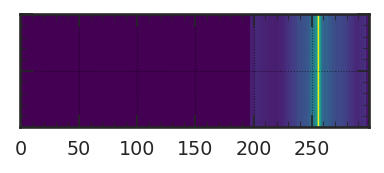

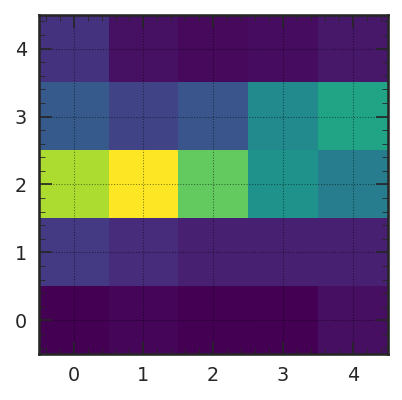

In [34]:
if do_annotations:
  ievt = 0
  #display_image(zone, images_gt[ievt], cmap=green_hot)

  fig, ax = plt.subplots(1, 1, figsize=(3,1))
  ax.imshow(np.atleast_2d(np.max(annotations[ievt], axis=0)), origin='lower', interpolation='none', aspect='auto')
  ax.set_yticklabels([])
  plt.show()

  fig, ax = plt.subplots(1, 1, figsize=(3,3))
  ax.imshow(np.max(annotations[ievt], axis=1).reshape(5,5), origin='lower', interpolation='none', aspect='auto')
  plt.show()

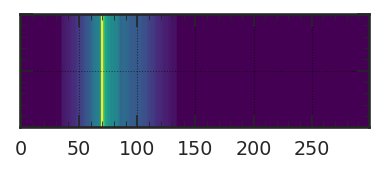

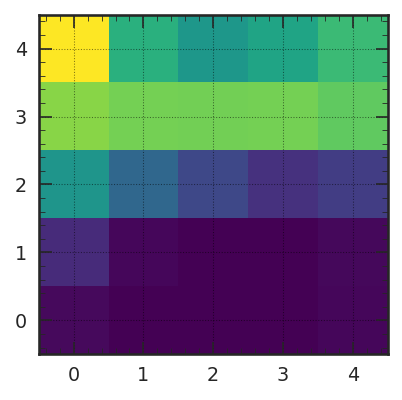

In [35]:
if do_annotations:
  ievt = 1
  #display_image(zone, images_gt[ievt], cmap=green_hot)

  fig, ax = plt.subplots(1, 1, figsize=(3,1))
  ax.imshow(np.atleast_2d(np.max(annotations[ievt], axis=0)), origin='lower', interpolation='none', aspect='auto')
  ax.set_yticklabels([])
  plt.show()

  fig, ax = plt.subplots(1, 1, figsize=(3,3))
  ax.imshow(np.max(annotations[ievt], axis=1).reshape(5,5), origin='lower', interpolation='none', aspect='auto')
  plt.show()

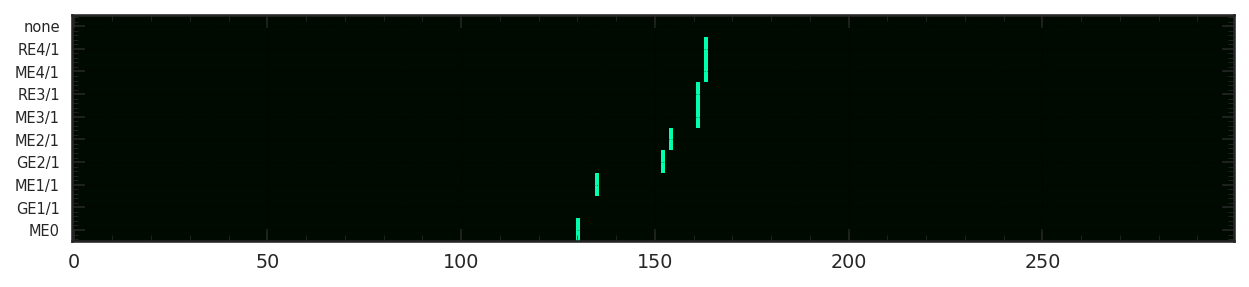

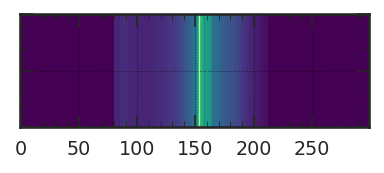

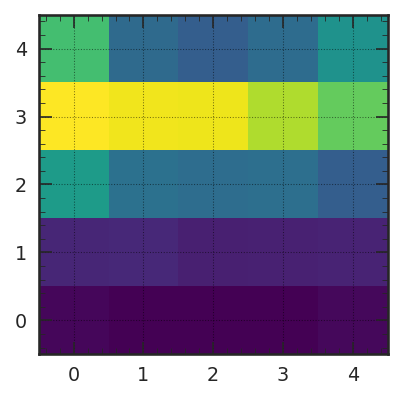

In [36]:
if do_annotations:
  ievt = 14
  display_image(zone, images_gt[ievt], cmap=green_hot)

  fig, ax = plt.subplots(1, 1, figsize=(3,1))
  ax.imshow(np.atleast_2d(np.max(annotations[ievt], axis=0)), origin='lower', interpolation='none', aspect='auto')
  ax.set_yticklabels([])
  plt.show()

  fig, ax = plt.subplots(1, 1, figsize=(3,3))
  ax.imshow(np.max(annotations[ievt], axis=1).reshape(5,5), origin='lower', interpolation='none', aspect='auto')
  plt.show()

In [37]:
if do_annotations:
  # Write
  outfile = 'annotations_zone%i.npz' % zone
  save_np_arrays(outfile, dict(annotations=annotations))
  logger.info('Wrote to {0}'.format(outfile))
else:
  # Read
  infile = 'annotations_zone%i.0.npz' % zone
  logger.info('Loading from {0}'.format(infile))
  with np.load(infile) as f:
    annotations = f['annotations']

[INFO    ] Wrote to annotations_zone0.npz
